In [1]:
!unzip files.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/images/03834.jpg  
  inflating: train/images/02981.jpg  
  inflating: train/images/03509.jpg  
  inflating: train/images/05617.jpg  
  inflating: train/images/03788.jpg  
  inflating: train/images/00696.jpg  
  inflating: train/images/00065.jpg  
  inflating: train/images/05270.jpg  
  inflating: train/images/02194.jpg  
  inflating: train/images/04461.jpg  
  inflating: train/images/03729.jpg  
  inflating: train/images/05386.jpg  
  inflating: train/images/04277.jpg  
  inflating: train/images/05063.jpg  
  inflating: train/images/03776.jpg  
  inflating: train/images/01912.jpg  
  inflating: train/images/00638.jpg  
  inflating: train/images/04965.jpg  
  inflating: train/images/02600.jpg  
  inflating: train/images/00408.jpg  
  inflating: train/images/01639.jpg  
  inflating: train/images/00809.jpg  
  inflating: train/images/03688.jpg  
  inflating: train/images/04301.jpg  
  inflating: train/i

In [27]:
import numpy as np
import glob
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import PIL.Image
import torchvision.transforms.v2 as T
import os
import albumentations as A
import albumentations.pytorch.transforms

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using the GPU 😊")
else:
    DEVICE = torch.device("cpu")
    print("Using the CPU 😞")

NETWORK_SIZE = (96, 96)
BATCH_SIZE = 16

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

START_TRANSFORM = A.Compose(
    [
    A.Resize(*NETWORK_SIZE),
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

DEFAULT_TRANSFORM = A.Compose(
    [
    A.ToFloat(max_value=255),
    A.Normalize(max_pixel_value=1.0, mean=IMAGENET_MEAN, std=IMAGENET_STD),
    A.pytorch.transforms.ToTensorV2(),
    ]
)
DEFAULT_AUGMENTATION = A.Compose(
    [
        A.RandomResizedCrop(width=NETWORK_SIZE[0], height=NETWORK_SIZE[0], scale=(0.9, 1), p=0.3),
        A.Rotate(limit=20, p=0.8, crop_border=False),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

FLIP = A.Compose(
    [
        A.HorizontalFlip(p=1),
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

def get_augment(image, pts):
    transformed = DEFAULT_AUGMENTATION(image=image, keypoints=pts)
    new_pts = transformed['keypoints']
    if new_pts.shape[0] != 14:
        new_pts = new_pts[14*4:14*5]
    if (transformed['keypoints'].shape[0] not in {14, 14 * 9} or
        np.any(new_pts < 0) or np.any(new_pts > NETWORK_SIZE[0])):
        return image, pts

    image = transformed['image']
    pts = new_pts
    if np.random.uniform(0, 1) < 0.5:
        transformed = FLIP(image=image, keypoints=pts)
        image, pts = transformed['image'], transformed['keypoints']
        # 0-3, 1-2, 4-9, 5-8, 6-7, 11-13, 10, 12
        pts[[0, 3]] = pts[[3, 0]]
        pts[[1, 2]] = pts[[2, 1]]
        pts[[4, 9]] = pts[[9, 4]]
        pts[[5, 8]] = pts[[8, 5]]
        pts[[6, 7]] = pts[[7, 6]]
        pts[[11, 13]] = pts[[13, 11]]
    return image, pts

class FacePtsDataset(Dataset):
    def __init__(self, img_dir, gt : dict, mode, train_fraction=0.8, rnd_seed=42, transform=None):
        img_paths = glob.glob(f'{img_dir}/*')

        X_train, X_valid = train_test_split(img_paths, train_size=train_fraction, random_state=rnd_seed)

        if mode == 'train':
            self._paths = X_train
        elif mode == 'valid':
            self._paths = X_valid
        else:
            raise RuntimeError(f"Invalid mode: {mode!r}")

        self._len = len(self._paths)
        self._gt = gt
        self._mode = mode
        if transform is None:
            self._transform = DEFAULT_TRANSFORM
        else:
            self._transform = transform

    def __getitem__(self, index):
        img_path = self._paths[index]
        filename = img_path.split('/')[-1]
        gt_pts = np.array(self._gt[filename]).reshape((-1, 2))

        image = np.array(PIL.Image.open(img_path).convert("RGB"))

        transformed = START_TRANSFORM(image=image, keypoints=gt_pts)
        image, gt_pts = transformed['image'], transformed['keypoints']
        if self._mode == 'train':
            image, gt_pts = get_augment(image, gt_pts)

        image = DEFAULT_TRANSFORM(image=image)['image']
        return image, (gt_pts / NETWORK_SIZE[0]).reshape((-1))

    def __len__(self):
        return self._len

class FacePtsBlock(nn.Module):
    def __init__(self, inp_c, out_c, kernel_size, drop_p=0.1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(inp_c, out_c, kernel_size, padding='same')
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, padding='same')
        self.elu = nn.ELU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(out_c, momentum=0.1)
        self.bn2 = nn.BatchNorm2d(out_c, momentum=0.1)
        self.drop = nn.Dropout(p=drop_p)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.elu(x)
        #ident = x
        #x = self.conv2(x)
        #x = self.elu(x + ident)
        x = self.maxpool(x)
        return x


class FacePtsModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.model = nn.Sequential(
            FacePtsBlock(3, 32, 4),
            FacePtsBlock(32, 64, 3),
            FacePtsBlock(64, 128, 3),
            FacePtsBlock(128, 256, 3),

            nn.Flatten(),
            nn.Linear(256 * (NETWORK_SIZE[0] // 2**4)**2, 1000),
            #nn.BatchNorm1d(1000, momentum=0.1),
            nn.ELU(),
            #nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            #nn.BatchNorm1d(1000, momentum=0.1),
            nn.LeakyReLU(),
            #nn.Dropout(p=0.5),
            nn.Linear(1000, 28),
        )

    def forward(self, x):
        return self.model(x)


def train_detector(train_gt : dict, train_img_dir : str,
                   epoch_cnt=5, lr=0.01,
                   fast_train : bool = False):
    ds_train = FacePtsDataset(train_img_dir, train_gt, mode="train")
    ds_valid = FacePtsDataset(train_img_dir, train_gt, mode="valid")

    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=os.cpu_count(),
    )
    dl_valid = DataLoader(
        ds_valid,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        num_workers=os.cpu_count(),
    )

    model = FacePtsModel().to(DEVICE)
    loss_fn = torch.nn.MSELoss().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-4)#, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20)

    for epoch in range(epoch_cnt):
        progress_train = tqdm(
            total=len(dl_train),
            desc=f"Epoch {epoch}",
            leave=False,
        )

        train_loss_ls = []
        model.train()
        for x_batch, y_batch in dl_train:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            pts_cords = model(x_batch)
            loss = loss_fn(pts_cords, y_batch)  # Calc loss
            train_loss_ls.append(loss.detach())
            loss.backward()
            optimizer.step() # Backward
            optimizer.zero_grad()
            progress_train.update()
        scheduler.step()
        print(
            f"Epoch {epoch},",
            f"train_loss: {100**2 * torch.stack(train_loss_ls).mean().item():.8f}",
        )

        progress_train.close()

        progress_valid = tqdm(
            total=len(dl_valid),
            desc=f"Epoch {epoch}",
            leave=False,
        )
        model.eval()
        valid_loss_ls = []
        for x_batch, y_batch in dl_valid:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            with torch.no_grad():
                pts_cords = model(x_batch)
                loss = loss_fn(pts_cords, y_batch)  # Calc loss
            valid_loss_ls.append(loss.detach())
            progress_valid.update()
        progress_valid.close()
        val_loss = 100**2 * torch.stack(valid_loss_ls).mean().item()
        print(
            f"Epoch {epoch},",
            f"valid_loss: {val_loss:.8f}",
        )
        if val_loss < 7:
            torch.save(model.state_dict(), 'facepoints_model_acc7.pt')
            print("All is good")

        if val_loss < 4.5:
            torch.save(model.state_dict(), 'facepoints_model_acc5.pt')
            print("All is great")

    if not fast_train:
        torch.save(model.state_dict(), 'facepoints_model.pt')

    return model


def detect(model_filename, test_img_dir):
    model = FacePtsModel().to(DEVICE)
    model.load_state_dict(torch.load(model_filename, DEVICE, weights_only=True))
    model.eval()
    results = dict()
    img_paths = glob.glob(f'{test_img_dir}/*')
    progress_train = tqdm(
        total=len(img_paths),
        leave=False,
    )
    for img_path in img_paths:
        filename = img_path.split('/')[-1]
        image = np.array(PIL.Image.open(img_path).convert("RGB"))
        sz = image.shape
        image = DEFAULT_TRANSFORM(image=START_TRANSFORM(image=image)['image'])['image']
        with torch.no_grad():
            coords = model(image[None,].to(DEVICE)).reshape((-1))

        coords = torch.clip(coords, 0, 1).to(torch.device("cpu"))
        coords[0::2] *= sz[1]
        coords[1::2] *= sz[0]
        coords = coords.tolist()
        results[filename] = coords
        progress_train.update()

    progress_train.close()
    return results


Using the GPU 😊


In [16]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res

train_gt = read_csv(os.path.join('train', 'gt.csv'))
model = train_detector(train_gt, 'train/images',
                       epoch_cnt=30, lr=0.001,
                       fast_train=False)

Epoch 0:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt
result = detect('facepoints_model_acc5.pt', 'test/images')

  0%|          | 0/6000 [00:00<?, ?it/s]

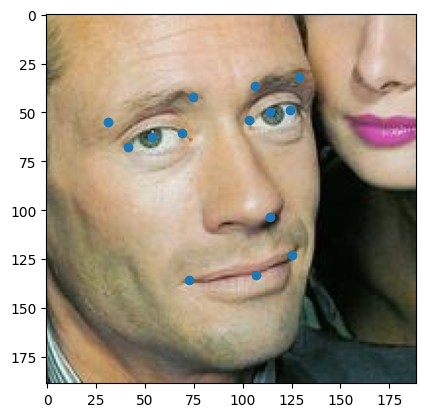

In [14]:
img_name = '00004.jpg'
pts = np.array(result[img_name])
image = np.array(PIL.Image.open('test/images/' + img_name).convert("RGB"))

plt.imshow(image)
plt.scatter(pts[0::2], pts[1::2])
plt.show()

In [28]:
test_result = detect('facepoints_model_acc5.pt', 'test/images')
test_gt = read_csv('gt.csv')
test_shapes = read_csv('img_shapes.csv')
mse_test = 0
for img_name in test_gt.keys():
    diff = test_gt[img_name] - test_result[img_name]
    diff[0::2] /= test_shapes[img_name][1]
    diff[1::2] /= test_shapes[img_name][0]
    diff *= 100
    mse_test += (diff ** 2).mean()
mse_test /= len(test_gt)
print(mse_test)

  0%|          | 0/6000 [00:00<?, ?it/s]

4.078103043021593
